# Census Visualization: Dashboard 

author: Keanna Knebel 

date: 2020-06-03

In [2]:
import pandas as pd
import geopandas as gpd
import json
import altair as alt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import csv

from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_bootstrap_components as dbc
import dash_html_components as html
from dash.dependencies import Input, Output

px.set_mapbox_access_token('pk.eyJ1IjoiY29jbzE4IiwiYSI6ImNrYXpyNzlldjAxMHAyc3F1dHFyNzFxcm8ifQ.x3S3Icl2TOpsoQsP21dTpQ')

In [3]:
# Load Data
df = pd.read_csv("../../data/processed/census_2016/visible_minority.csv")
list(df.columns)


['Unnamed: 0',
 'LocalArea',
 'Total population',
 'Not a visible minority',
 'Total visible minority population',
 'Arab',
 'Black',
 'Chinese',
 'Filipino',
 'Japanese',
 'Korean',
 'Latin American',
 'West Asian',
 'South Asian',
 'Southeast Asian',
 'Multiple visible minorities',
 'Other visible minority']

In [42]:
# Load Data
df = pd.read_csv("../../data/processed/census_viz.csv")
x = list(df.columns)


boundary = gpd.read_file("../../data/raw/local_area_boundary.geojson")
licence = pd.read_csv("../../data/processed/vis_licence.csv")
agg_licence = pd.read_csv("../../data/processed/vis_agg_licence.csv")

In [43]:
pop_df = df[['LocalArea', 'Year', 'Age_total']]
pop_df

,LocalArea,Year,Age_total
0,Arbutus-Ridge,2001,14515.0
1,Downtown,2001,27985.0
2,Fairview,2001,28430.0
3,Grandview-Woodland,2001,29100.0
4,Hastings-Sunrise,2001,33050.0
...,...,...,...
87,Oakridge,2016,13020.0
88,Renfrew-Collingwood,2016,51535.0
89,Sunset,2016,36495.0
90,West Point Grey,2016,13065.0


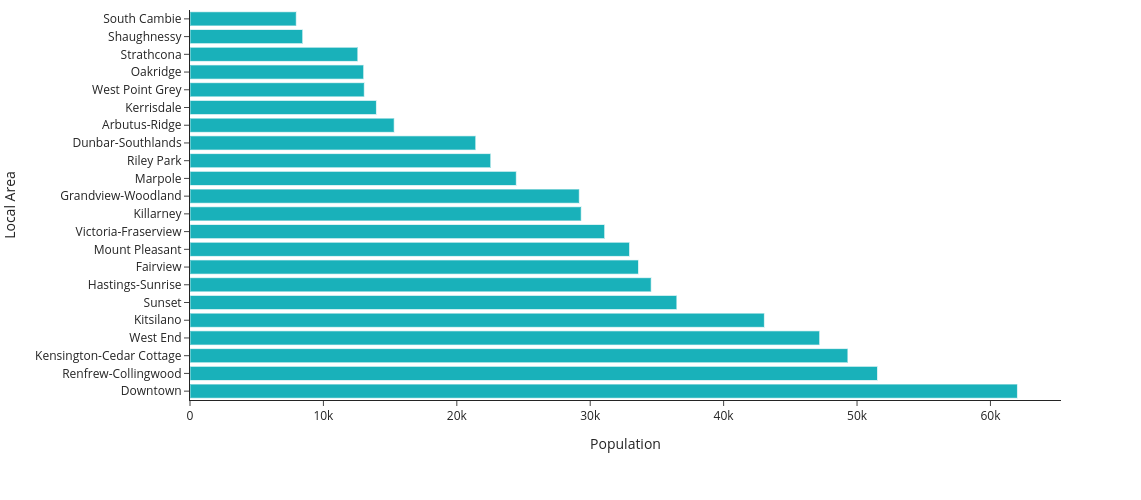

In [51]:

census_year = 2016
pop_df = df[['LocalArea', 'Year', 'Age_total']]
pop_df = pop_df[(pop_df.Year == census_year) & (pop_df.LocalArea != 'Metro Vancouver')]
pop_df = pop_df.sort_values(by='Age_total', ascending=False)
pop_fig = go.Figure(
        data=go.Bar(
            x=pop_df["Age_total"],
            y=pop_df['LocalArea'],
            marker_color='#19B1BA',
            orientation='h'),
        layout=go.Layout(
            template='simple_white',
            margin=dict(l=100, b=100, t=10)))
pop_fig.update_layout(
        xaxis={'title': "Population"},
        yaxis_title="Local Area",
        showlegend=False,
        height=500,
        width=700)
pop_fig

In [5]:
area = 'Downtown'
census_year = 2016
lang = df[['LocalArea', 'Year', 'English','French', 'Chinese languages',
                             'Tagalog (Filipino)',
                             'Panjabi (Punjabi)',
                             'Italian', 'German',
                             'Spanish', 'Vietnamese',
                             'Korean language', 'Hindi',
                             'Persian (Farsi)']]
lang = lang[(lang.Year == census_year) & (lang.LocalArea.isin([area, 'Metro Vancouver']))]
#lang = lang.melt(id_vars=['Year'],
                     #    var_name='LANGUAGES',
                      #   value_name=[area.upper(), 'METRO VANCOUVER'])

lang.drop(columns=['Year'], inplace=True)
lang.set_index('LocalArea', inplace=True)
lang = lang.T
lang = lang.sort_values(by=[area], ascending=False)
lang.reset_index(inplace=True)
lang = lang[0:5].copy()
lang

LocalArea,index,Downtown,Metro Vancouver
0,English,0.559279,0.530144
1,Chinese languages,0.125994,0.221552
2,Persian (Farsi),0.058894,0.012681
3,Korean language,0.033507,0.012938
4,Spanish,0.028720,0.019886


In [6]:
fig = go.Figure(data=[go.Table(
    header=dict(values=list(lang.columns),
                fill_color='paleturquoise',
                align='center',
                font_size=25,
                height=45),
    cells=dict(values=[lang['LANGUAGES'], round(lang[area.upper()]*100, 2)],

               fill=dict(color=['white']),
               align=['center'],
               font_size=20,
               height=40))
])

fig.show()

SyntaxError: invalid syntax (<ipython-input-6-1e03514b4c87>, line 8)

In [13]:
biz_df = agg_licence[(agg_licence.FOLDERYEAR == 2000) & (agg_licence.LocalArea == 'Downtown')]
biz_df = pd.DataFrame(
       biz_df.groupby(['LocalArea', 'FOLDERYEAR'])[
            'business_id'].sum()).reset_index()
biz_df

,LocalArea,FOLDERYEAR,business_id
0,Downtown,2000,7644


In [85]:
year = 2016
area = 'West Point Grey'
area = 'Downtown'
age_df = df[['LocalArea', 'Year',
                 'Under 20',
                 '20 to 34',
                 '35 to 44',
                 '45 to 54',
                 '55 to 64',
                 '65 to 79',
                 '80 and Older']]

age_df = age_df[(age_df.Year == year) & (age_df.LocalArea == area)]
age_df = age_df.melt(id_vars=['LocalArea', 'Year'], var_name='Age', value_name='Population')
age = age_df[age_df.Population == age_df.Population.max()].reset_index()
age.Population[0]
#age.Age[0]

22610.0

In [3]:
# make local area map graph
def make_van_map(neighbour=None):
    colour = ['blue'] * 22
    
    if neighbour is not None:
        colour[boundary[boundary.name == neighbour].index[0]] = 'red'
    
    choro = px.choropleth_mapbox(boundary,
                             geojson= boundary,
                             locations='name',
                             featureidkey='properties.name',
                             opacity=0.5,
                             color=colour,
                             hover_name = 'name',
                             mapbox_style="carto-positron",
                             center={"lat": 49.250, "lon": -123.121},
                             zoom=11,
                             height=600,
                             width=1200)
    choro.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    return choro

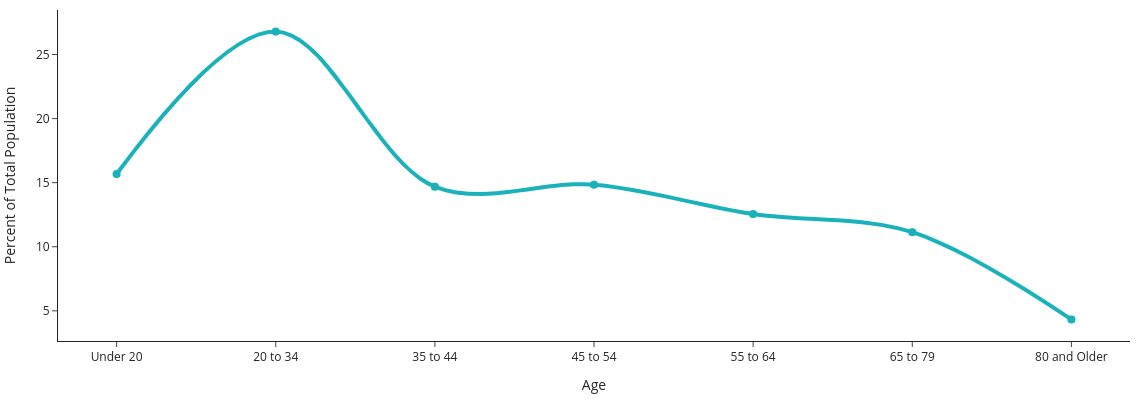

In [18]:
# Demographic Data
year = 2016
neighbourhood = 'Metro Vancouver'


age_df = df[['LocalArea', 'Year', 
 'Under 20',
 '20 to 34',
 '35 to 44',
 '45 to 54',
 '55 to 64',
 '65 to 79',
 '80 and Older']]

age_df = age_df[(age_df.Year == year) & (age_df.LocalArea == neighbourhood)]
age_df
new_df = age_df.melt(id_vars=['LocalArea', 'Year'], var_name='Age', value_name='Population')
age_fig = px.bar(new_df, 
             x="Age", 
             y="Population", 
             hover_data=['Population'],
             width=500, 
             height=300,
             template='simple_white',
             color_discrete_sequence = ['#19B1BA'])

age_fig = go.Figure(
        data=go.Scatter(
            x=new_df['Age'],
            y=new_df['Population']*100,
            mode='lines+markers',
            marker=dict(
                color='#19B1BA',
                size=8),
            name=area,
            line=dict(width=4),
            line_shape='spline',
            hovertemplate="%{x}: %{y:.1f}%<extra></extra>"),

        layout=go.Layout(
            margin=dict(l=10, r=10, b=10, t=10),
            template='simple_white'))
age_fig.update_layout(
        xaxis_title="Age",
        yaxis_title="Percent of Total Population",
        showlegend=False,
        legend=dict(x=1, y=1,
                    xanchor="right"),
        height=400, width=700)
#age_fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

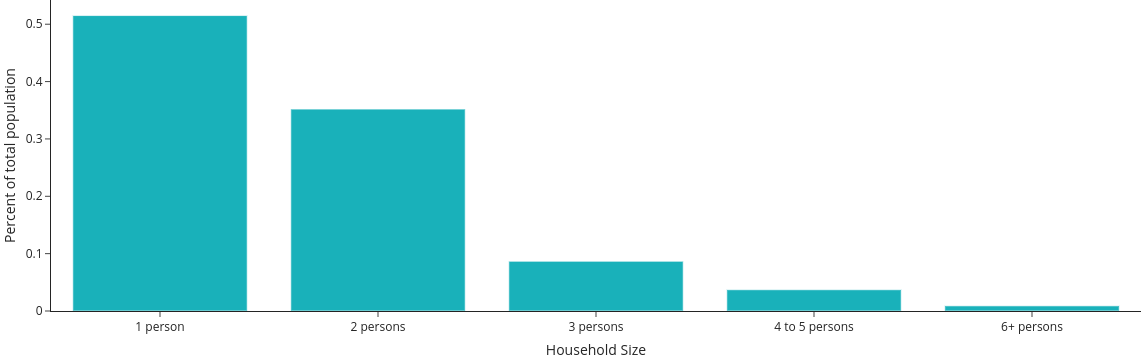

In [5]:
size_df = df[['LocalArea', 'Year','1 person',
 '2 persons',
 '3 persons',
 '4 to 5 persons',
 '6+ persons']]
size_df = size_df[(size_df.Year == year) & (size_df.LocalArea == neighbourhood)]
size_df = size_df.melt(id_vars=['LocalArea', 'Year'], var_name='Household Size', value_name='Percent of total population')
size_fig = px.bar(size_df, 
             x="Household Size", 
             y='Percent of total population', 
             hover_data=['Percent of total population'],
             width=500, 
             height=300,
             template='simple_white',
             color_discrete_sequence = ['#19B1BA'])
size_fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

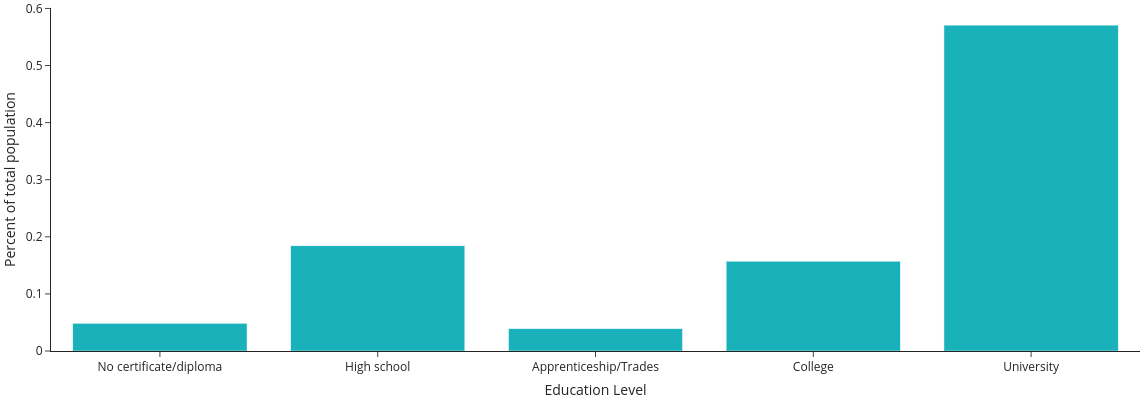

In [6]:
edu_df = df[['LocalArea', 'Year',
             'No certificate/diploma',
 'High school',
 'Apprenticeship/Trades',
 'College',
 'University']]
edu_df = edu_df[(edu_df.Year == year) & (edu_df.LocalArea == neighbourhood)]
edu_df = edu_df.melt(id_vars=['LocalArea', 'Year'], var_name='Education Level', value_name='Percent of total population')
edu_fig = px.bar(edu_df, 
             x="Education Level", 
             y='Percent of total population', 
             hover_data=['Percent of total population'],
             width=500, 
             height=400,
             template='simple_white',
             color_discrete_sequence = ['#19B1BA'])
edu_fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

In [7]:
# Build App
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = JupyterDash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

### App Layout Begins ###
app.layout = html.Div([
    
    # Main app header
    html.Div([
        # Setting the main title of the Dashboard
        html.H1("Forecasting the Evolution of Vancouver's Business Landscape",
                style={"textAlign": "center", 'fontFamily': 'arial',
                       'marginTop': 50, 'marginBottom': 50, 
                       'marginLeft': 100, 'marginRight': 100})],
        style={'Color': '#2E4053'}),
    
    # Dividing the dashboard in 3 tabs
    dcc.Tabs(id="mainTabs", children=[
        
        # Define the layout of the first Tab
        dcc.Tab(label='Main', children=[
            
                ]),
        
        # Define the layout of the second Tab
        dcc.Tab(label='Neighbourhood Profiles', children=[
            
            # neighbourhood tab header 
            html.Div([
                html.H2("VANCOUVER NEIGHBOURHOODS", style={"textAlign": "center"}),
                html.H6("Click the map to explore Vancouver Neighbourhoods",
                        style={"textAlign": "center"})], 
                style={'marginTop': 50}),
            
            # main map of neighbourhoods 
            dcc.Graph(id='van_map',
                      figure=make_van_map(), 
                      config=config),
            
            # Adding tabs for summary neighbourhood data
            dcc.Tabs(id="subTabs", children=[
                
                # summary of local demographics
                dcc.Tab(label='People', children=[
                    
                    # population by age
                    dbc.Row([
                        dbc.Col([
                            html.H4('Age Distribution', style={"textAlign": "center"}),
                            dcc.Graph(figure=age_fig, config=config, style={"width":"100%"})
                        ], align='center'),
                        dbc.Col([
                            html.H5('text description...')
                        ])
                    ], style={'marginTop': 100}),
                    
                    # population by household size
                    dbc.Row([
                        dbc.Col([
                            html.H4('Household Size', style={"textAlign": "center"}),
                            dcc.Graph(figure=size_fig, config=config, style={"width":"100%"})
                        ], align='center'),
                        dbc.Col([
                            html.H5('text description...')
                        ])
                    ], style={'marginTop': 100}),
                    
                    # population by language
                    dbc.Row([
                        dbc.Col([
                            html.H4('Languages + Ethnicities', style={"textAlign": "center"}),
                            dcc.Graph(figure=age_fig, config=config, style={"width":"100%"})
                        ]),
                        dbc.Col([
                            html.H5("text description...composition of the spoken language and ethnicity in the neighbourhood.")
                        ])
                    ], style={'marginTop': 100}),
                    
                    # population by education level
                    dbc.Row([
                        dbc.Col([
                            html.H4('Education Level', style={"textAlign": "center"}),
                            dcc.Graph(figure=edu_fig, config=config, style={"width":"100%"})
                        ]),
                        dbc.Col([
                            html.H5('text description...')
                        ])
                    ], style={'marginTop': 100}),
                ]),
                
                # summary of local business structure
                dcc.Tab(label='Businesses', children=[
            
                ]),
                
                # summary of local infrastructure
                dcc.Tab(label='Infrastructure', children=[
            
                ]),
           
            ], style={'marginTop': 50}),
        ]),
        
        # Define the layout of the third Tab
        dcc.Tab(label='Sources')
    ]),
    
    # main app footer
    html.Footer([
        
        html.H4("PROJECT PARTNERS", style={"textAlign": "center", 'marginBottom': 50}),
        dbc.Row([
            dbc.Col([
                html.Img(src="https://brand3.sites.olt.ubc.ca/files/2018/09/5NarrowLogo_ex_768.png", 
                         style={"width":"100%"})],
                width=4, align='end'),
            dbc.Col([
                html.Img(src="https://deetken.com/wp-content/uploads/2019/02/logo-1.png", 
                         style={"width":"100%"})],
                width=4)
        ], justify="center"),
    ], style={'marginTop': 100}),
])



NameError: name 'config' is not defined

In [ ]:
# Define callback to update graph
@app.callback(
    Output('van_map', 'figure'),
    [Input('van_map', 'clickData')])

def update_van_map(clickData):
    if clickData is not None:
        van_map = make_van_map(neighbour=clickData['location'])
    else:
        van_map = make_van_map()
    return van_map

In [ ]:
# Run app and display result in seperate tab/notebook
app.run_server(mode="jupyterlab", debug=True)